# Taller 7: Detección de Árboles con DeepForest

**Autores:**
- Juan Pablo Ávila
- Maicol Ardila 
- Jesús Jacome

### 1. Instalación de Dependencias

Antes de comenzar, es necesario instalar las librerías de Python que utilizaremos en este proyecto. Este comando se encarga de instalar:

- **`deepforest`**: La librería principal para la detección de copas de árboles.
- **`albumentations`**: Una librería de aumentación de imágenes, requerida como dependencia por `deepforest` para su correcto funcionamiento.

El indicador `-q` (quiet) se usa para que la instalación se realice de forma silenciosa, mostrando menos texto en la salida.

In [11]:
print("Paso 1: Instalando librerías necesarias...")
!pip install deepforest -q
!pip install albumentations==1.3.1 -q
print("Instalación completada.")

Paso 1: Instalando librerías necesarias...
Instalación completada.


### 2. Ejecución del Modelo de Detección

Este script ejecuta el núcleo del análisis. Carga un modelo de `deepforest` ya entrenado para reconocer árboles, lo prepara para usar el hardware más eficiente (GPU o CPU) y lo aplica sobre una imagen de prueba.

El resultado final, que se imprime en pantalla, es una tabla que resume las detecciones. Cada fila representa un árbol encontrado, detallando su ubicación en la imagen (`xmin`, `ymin`, `xmax`, `ymax`) y el nivel de confianza (`score`) que el modelo tiene en esa predicción.

In [12]:

print("Importando librerías...")
import os 
from deepforest import get_data
from deepforest import main
import torch
from PIL import Image
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
print("Importaciones exitosas.")

print("\nCargando imagen de ejemplo directamente desde la librería DeepForest...")
image_path = get_data("SOAP_061.png")

img_pil = Image.open(image_path)
print(f"Imagen cargada correctamente: '{os.path.basename(image_path)}' con dimensiones {img_pil.size}")

model = main.deepforest()
model.use_release(check_release=True)


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando dispositivo: {device}")
model.to(device)

print("Realizando la detección de árboles...")
predicciones_df = model.predict_image(path=image_path, return_plot=False)

if predicciones_df is None or predicciones_df.empty:
    raise ValueError("DeepForest no detectó ningún árbol. Esto es inesperado.")
else:
    print(f"¡Éxito! Se detectaron {len(predicciones_df)} árboles.")

print("\n--- Vista previa de las predicciones ---")
print(predicciones_df.head())

Importando librerías...
Importaciones exitosas.

Cargando imagen de ejemplo directamente desde la librería DeepForest...
Imagen cargada correctamente: 'SOAP_061.png' con dimensiones (400, 400)
Reading config file: c:\Users\Juan Pablo\anaconda3\envs\deepforest\Lib\site-packages\deepforest\data\deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Reading config file: c:\Users\Juan Pablo\anaconda3\envs\deepforest\Lib\site-packages\deepforest\data\deepforest_config.yml


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Usando dispositivo: cpu
Realizando la detección de árboles...
¡Éxito! Se detectaron 37 árboles.

--- Vista previa de las predicciones ---
    xmin   ymin   xmax   ymax label     score    image_path  \
0  273.0  230.0  313.0  275.0  Tree  0.882637  SOAP_061.png   
1   47.0   82.0   81.0  120.0  Tree  0.740917  SOAP_061.png   
2    0.0   72.0   34.0  116.0  Tree  0.735854  SOAP_061.png   
3  341.0   40.0  374.0   77.0  Tree  0.668238  SOAP_061.png   
4    0.0  183.0   26.0  235.0  Tree  0.664885  SOAP_061.png   

                                            geometry  
0  POLYGON ((313 230, 313 275, 273 275, 273 230, ...  
1    POLYGON ((81 82, 81 120, 47 120, 47 82, 81 82))  
2      POLYGON ((34 72, 34 116, 0 116, 0 72, 34 72))  
3  POLYGON ((374 40, 374 77, 341 77, 341 40, 374 ...  
4   POLYGON ((26 183, 26 235, 0 235, 0 183, 26 183))  


### 3. Visualización de Resultados en la Imagen

Una vez obtenidas las coordenadas de los árboles, el siguiente paso es **visualizarlas directamente sobre la imagen** para verificar la precisión del modelo.

Este código realiza las siguientes acciones:
1.  **Carga la imagen** utilizando la librería `OpenCV`, que es ideal para tareas de dibujo y manipulación de imágenes. Se convierte el formato de color de BGR a RGB para una visualización correcta.
2.  **Recorre cada una de las detecciones** guardadas en la tabla `predicciones_df`.
3.  Para cada árbol detectado, **dibuja un rectángulo verde** (`cv2.rectangle`) que corresponde a su caja delimitadora.
4.  Adicionalmente, **añade un identificador numérico único** (`cv2.putText`) encima de cada caja. Esto permite referenciar y contar fácilmente cada árbol individual.
5.  Finalmente, **muestra la imagen resultante** con todas las anotaciones usando `matplotlib`, ofreciendo una clara representación visual de los resultados.

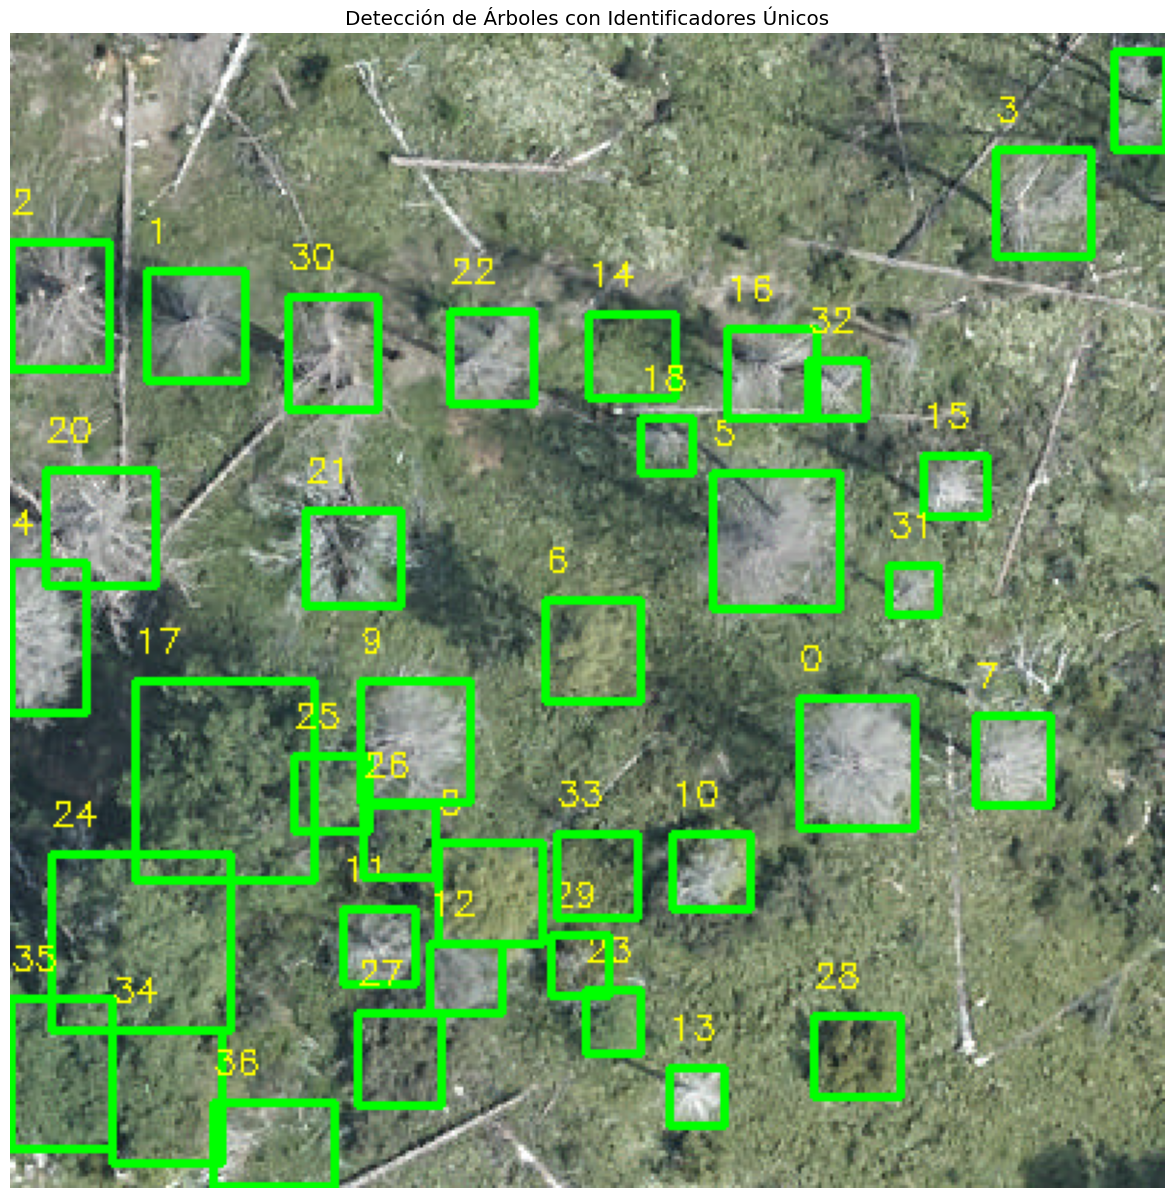

In [13]:
image_cv = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB)

image_con_cajas = image_rgb.copy()

for index, row in predicciones_df.iterrows():

    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])

    
    cv2.rectangle(image_con_cajas, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    id_arbol = index
    cv2.putText(
        img=image_con_cajas,
        text=str(id_arbol),
        org=(xmin, ymin - 10),  
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.4,          
        color=(255, 255, 0),    
        thickness=1             
    )


plt.style.use('ggplot')
plt.figure(figsize=(15, 15))
plt.imshow(image_con_cajas)
plt.title("Detección de Árboles con Identificadores Únicos")
plt.axis('off')  
plt.show()

### 4. Enriquecimiento de Datos y Cálculo de Área

Para facilitar análisis posteriores, no solo nos basta con las coordenadas. En este paso, preparamos y enriquecemos la tabla de resultados (`DataFrame`) con información adicional.

Las operaciones realizadas son:
1.  **Crear un DataFrame de análisis**: Se genera una copia de las predicciones originales para no modificar los datos brutos.
2.  **Asignar un ID único**: Se añade una columna `id_arbol` que sirve como identificador único para cada detección, lo cual es fundamental para el seguimiento y análisis individual de cada árbol.
3.  **Calcular el área de la copa**: Se crea una nueva columna `area_px` que contiene el área de la caja delimitadora de cada árbol, calculada en píxeles cuadrados (`ancho * alto`). Este dato puede ser un indicador aproximado del tamaño de la copa del árbol.
4.  **Reorganizar la tabla**: Se reordenan las columnas para mejorar la legibilidad y tener la información más relevante al principio.

La tabla resultante contiene ahora todos los datos necesarios para realizar análisis cuantitativos más avanzados.

In [14]:
df_analisis = predicciones_df.copy()

df_analisis = df_analisis.reset_index().rename(columns={'index': 'id_arbol'})

df_analisis['area_px'] = (df_analisis['xmax'] - df_analisis['xmin']) * (df_analisis['ymax'] - df_analisis['ymin'])

df_analisis = df_analisis[['id_arbol', 'xmin', 'ymin', 'xmax', 'ymax', 'score', 'label', 'area_px']]

print("DataFrame de análisis con áreas calculadas:")
df_analisis.head()

DataFrame de análisis con áreas calculadas:


,id_arbol,xmin,ymin,xmax,ymax,score,label,area_px
0,0,273.0,230.0,313.0,275.0,0.882637,Tree,1800.0
1,1,47.0,82.0,81.0,120.0,0.740917,Tree,1292.0
2,2,0.0,72.0,34.0,116.0,0.735854,Tree,1496.0
3,3,341.0,40.0,374.0,77.0,0.668238,Tree,1221.0
4,4,0.0,183.0,26.0,235.0,0.664885,Tree,1352.0


### 5. Cálculo de Índices de Vegetación por Árbol

Para ir más allá de la simple detección, podemos analizar las propiedades espectrales de cada árbol. En este bloque, calculamos dos **índices de vegetación** populares para cada copa detectada, utilizando los valores de los píxeles de la imagen RGB.

El proceso es el siguiente:
1.  Se itera sobre cada árbol en el `DataFrame` de análisis.
2.  Para cada uno, se **recorta la región de la imagen** que corresponde a su caja delimitadora.
3.  Dentro de esa región, se calculan dos índices píxel a píxel:
    - **Excess Green (ExG)**: Un índice que resalta la "verdosidad" de los píxeles, muy útil para separar la vegetación del suelo u otros elementos. Su fórmula es `2G - R - B`.
    - **Visible Atmospherically Resistant Index (VARI)**: Un índice diseñado para ser menos sensible a los efectos atmosféricos, que también mide la salud y densidad de la vegetación. Su fórmula es `(G - R) / (G + R - B)`.
4.  Finalmente, se calcula el **valor promedio** de cada índice para la totalidad de la copa del árbol y se añaden estos valores como nuevas columnas (`ExG_mean` y `VARI_mean`) a nuestro `DataFrame`.

Estos nuevos datos nos permitirán comparar cuantitativamente la "verdosidad" o el vigor entre los distintos árboles detectados.

In [15]:
epsilon = 1e-8

exg_means = []
vari_means = []

image_float = image_rgb.astype(np.float32)

for index, arbol in df_analisis.iterrows():
    xmin, ymin, xmax, ymax = int(arbol['xmin']), int(arbol['ymin']), int(arbol['xmax']), int(arbol['ymax'])

    region_arbol = image_float[ymin:ymax, xmin:xmax]

    R = region_arbol[:, :, 0]
    G = region_arbol[:, :, 1]
    B = region_arbol[:, :, 2]

    exg = 2 * G - R - B
    exg_means.append(np.mean(exg))

    denominator = G + R - B + epsilon
    vari = (G - R) / denominator
    vari_means.append(np.mean(vari))

df_analisis['ExG_mean'] = exg_means
df_analisis['VARI_mean'] = vari_means

print("DataFrame actualizado con índices de vegetación:")
df_analisis.head()

DataFrame actualizado con índices de vegetación:


,id_arbol,xmin,ymin,xmax,ymax,score,label,area_px,ExG_mean,VARI_mean
0,0,273.0,230.0,313.0,275.0,0.882637,Tree,1800.0,14.700556,0.052608
1,1,47.0,82.0,81.0,120.0,0.740917,Tree,1292.0,14.955882,0.091130
2,2,0.0,72.0,34.0,116.0,0.735854,Tree,1496.0,8.584893,0.047239
3,3,341.0,40.0,374.0,77.0,0.668238,Tree,1221.0,21.295660,0.055378
4,4,0.0,183.0,26.0,235.0,0.664885,Tree,1352.0,7.471154,0.061916


### 6. Análisis Comparativo de Histogramas de Color

Para entender las características espectrales que diferencian a los árboles del resto de la escena, podemos comparar la **distribución de los valores de color** de los píxeles.

Este código genera un análisis visual mediante histogramas:
1.  **Crea una máscara binaria**: Se construye una imagen en blanco y negro donde todos los píxeles que pertenecen a las cajas de los árboles se marcan como `1` (blanco) y el resto como `0` (negro).
2.  **Separa los píxeles**: Usando esta máscara, se dividen los píxeles de la imagen original en dos grupos: "píxeles de árboles" y "píxeles de no árboles".
3.  **Genera los histogramas**: Para cada canal de color (Rojo, Verde y Azul), se crea un gráfico que muestra la frecuencia de cada nivel de intensidad de píxel (de 0 a 255).
    - El histograma de los árboles (en color) se superpone al de los no árboles (en gris).
4.  **Visualiza la comparación**: Los gráficos resultantes nos permiten observar patrones. Por ejemplo, es esperable que los píxeles de los árboles muestren una mayor intensidad en el canal verde en comparación con el fondo.

Este análisis confirma visualmente por qué los índices de vegetación como ExG funcionan bien para distinguir la vegetación.

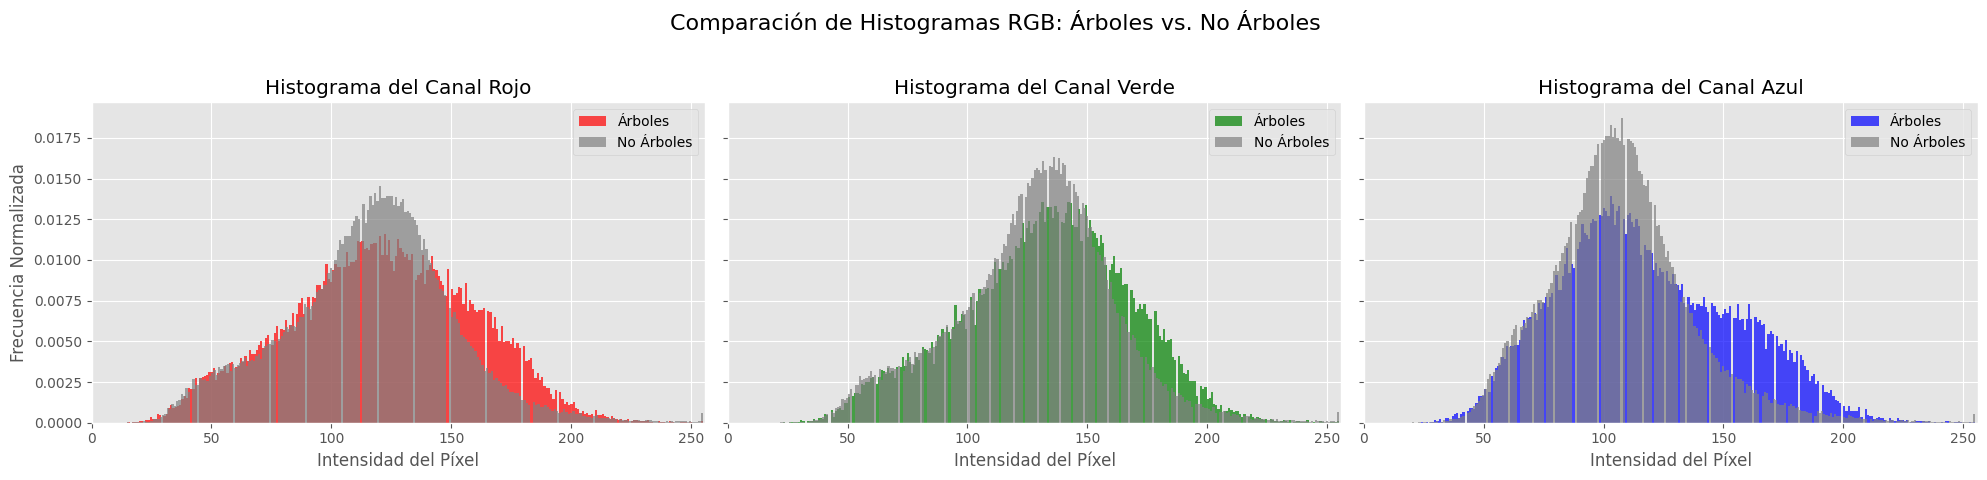

In [16]:
mask_arboles = np.zeros(image_rgb.shape[:2], dtype=np.uint8)
for index, row in df_analisis.iterrows():
    xmin, ymin, xmax, ymax = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
    mask_arboles[ymin:ymax, xmin:xmax] = 1

pixeles_arboles = image_rgb[mask_arboles == 1]
pixeles_no_arboles = image_rgb[mask_arboles == 0]

fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
colores = ['red', 'green', 'blue']
canales = ['Rojo', 'Verde', 'Azul']

for i, (color, canal) in enumerate(zip(colores, canales)):
    axes[i].hist(pixeles_arboles[:, i], bins=256, color=color, alpha=0.7, label='Árboles', density=True)
    axes[i].hist(pixeles_no_arboles[:, i], bins=256, color='gray', alpha=0.7, label='No Árboles', density=True)

    axes[i].set_title(f'Histograma del Canal {canal}')
    axes[i].set_xlabel('Intensidad del Píxel')
    axes[i].set_xlim(0, 256)
    axes[i].legend()

axes[0].set_ylabel('Frecuencia Normalizada')
plt.suptitle('Comparación de Histogramas RGB: Árboles vs. No Árboles', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 7. Análisis de Dispersión de Valores RGB

Para complementar los histogramas, un **diagrama de dispersión** nos ayuda a visualizar cómo se agrupan los valores de los píxeles en el espacio de color. Este análisis puede revelar si los árboles forman un clúster de color distintivo.

El procedimiento es el siguiente:
1.  **Calcular el color promedio**: Para cada árbol detectado, se calcula el valor promedio de los canales Rojo, Verde y Azul. Estos promedios se añaden al `DataFrame`.
2.  **Muestreo del fondo**: Se toma una muestra aleatoria de los píxeles que no pertenecen a los árboles para evitar sobrecargar el gráfico.
3.  **Crear los diagramas de dispersión**: Se generan tres gráficos:
    - Rojo vs. Verde
    - Verde vs. Azul
    - Rojo vs. Azul
4.  **Visualizar los grupos**: En cada gráfico, se muestran los píxeles del fondo (en gris) y los colores promedio de cada árbol (en verde). Esto nos permite observar si los árboles ocupan una región específica y separada en el espacio de color RGB.

Finalmente, se muestra una vista previa del `DataFrame` completo, que ahora contiene toda la información generada: coordenadas, ID, área, índices de vegetación y valores de color promedio.

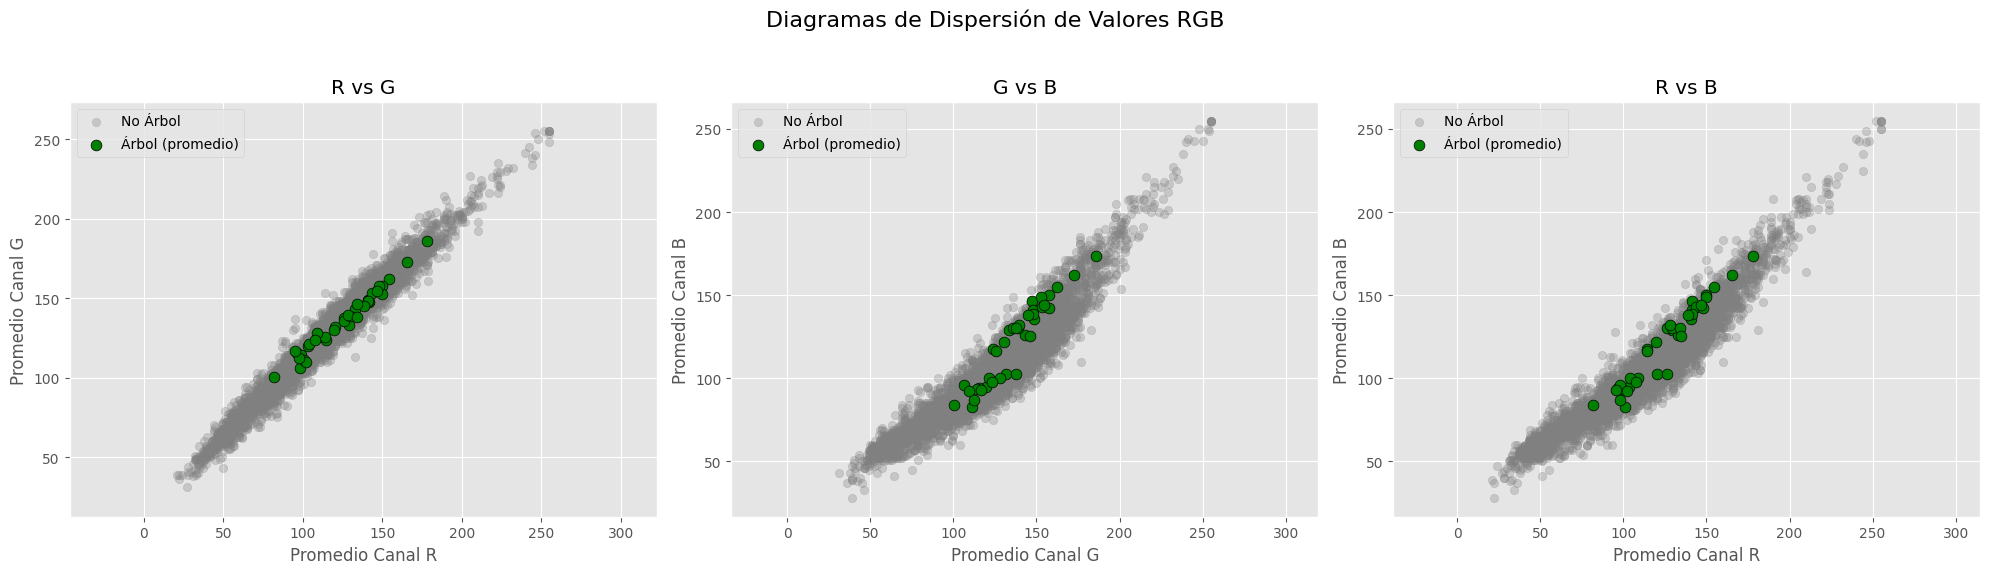


--- Vista Final del DataFrame de Análisis ---


,id_arbol,xmin,ymin,xmax,ymax,score,label,area_px,ExG_mean,VARI_mean,R_mean,G_mean,B_mean
0,0,273.0,230.0,313.0,275.0,0.882637,Tree,1800.0,14.700556,0.052608,154.483333,162.169444,155.155000
1,1,47.0,82.0,81.0,120.0,0.740917,Tree,1292.0,14.955882,0.091130,114.529412,123.571207,117.657121
2,2,0.0,72.0,34.0,116.0,0.735854,Tree,1496.0,8.584893,0.047239,128.985294,133.187166,128.804144
3,3,341.0,40.0,374.0,77.0,0.668238,Tree,1221.0,21.295660,0.055378,140.944308,148.816544,135.393120
4,4,0.0,183.0,26.0,235.0,0.664885,Tree,1352.0,7.471154,0.061916,141.493343,147.606509,146.248521


In [17]:
rgb_means = []
for index, arbol in df_analisis.iterrows():
    xmin, ymin, xmax, ymax = int(arbol['xmin']), int(arbol['ymin']), int(arbol['xmax']), int(arbol['ymax'])
    region_arbol = image_rgb[ymin:ymax, xmin:xmax]
    mean_rgb = np.mean(region_arbol, axis=(0, 1))
    rgb_means.append(mean_rgb)

df_analisis[['R_mean', 'G_mean', 'B_mean']] = pd.DataFrame(rgb_means, index=df_analisis.index)

np.random.seed(42) 
sample_size = min(5000, len(pixeles_no_arboles))
indices_muestra = np.random.choice(len(pixeles_no_arboles), sample_size, replace=False)
pixeles_no_arboles_muestra = pixeles_no_arboles[indices_muestra]


fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Gráfico 1: R vs G
axes[0].scatter(pixeles_no_arboles_muestra[:, 0], pixeles_no_arboles_muestra[:, 1], c='gray', alpha=0.3, label='No Árbol')
axes[0].scatter(df_analisis['R_mean'], df_analisis['G_mean'], c='green', edgecolor='k', s=60, label='Árbol (promedio)')
axes[0].set_xlabel('Promedio Canal R'); axes[0].set_ylabel('Promedio Canal G'); axes[0].set_title('R vs G'); axes[0].legend(); axes[0].axis('equal')

# Gráfico 2: G vs B
axes[1].scatter(pixeles_no_arboles_muestra[:, 1], pixeles_no_arboles_muestra[:, 2], c='gray', alpha=0.3, label='No Árbol')
axes[1].scatter(df_analisis['G_mean'], df_analisis['B_mean'], c='green', edgecolor='k', s=60, label='Árbol (promedio)')
axes[1].set_xlabel('Promedio Canal G'); axes[1].set_ylabel('Promedio Canal B'); axes[1].set_title('G vs B'); axes[1].legend(); axes[1].axis('equal')

# Gráfico 3: R vs B
axes[2].scatter(pixeles_no_arboles_muestra[:, 0], pixeles_no_arboles_muestra[:, 2], c='gray', alpha=0.3, label='No Árbol')
axes[2].scatter(df_analisis['R_mean'], df_analisis['B_mean'], c='green', edgecolor='k', s=60, label='Árbol (promedio)')
axes[2].set_xlabel('Promedio Canal R'); axes[2].set_ylabel('Promedio Canal B'); axes[2].set_title('R vs B'); axes[2].legend(); axes[2].axis('equal')

plt.suptitle('Diagramas de Dispersión de Valores RGB', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


print("\n--- Vista Final del DataFrame de Análisis ---")
df_analisis.head()

### 8. Exportación de Resultados

Una vez completado todo el análisis, el paso final es **guardar los resultados** para su uso futuro, ya sea en otro software (como QGIS o Excel) o para documentar el trabajo.

Este bloque de código realiza dos acciones clave:
1.  **Guarda el `DataFrame`** completo, que contiene toda la información recopilada (coordenadas, IDs, áreas, índices de vegetación, etc.), en un archivo de formato **CSV** (`Comma-Separated Values`). Este formato es universal y fácil de abrir en la mayoría de los programas de análisis de datos.
2.  **Facilita la descarga**: Si el notebook se está ejecutando en Google Colab, el código intenta generar un enlace de descarga directa para el archivo CSV. Si se ejecuta en un entorno local, el archivo se guardará en la misma carpeta que el notebook.

In [18]:

nombre_archivo_csv = 'analisis_arboles.csv'
df_analisis.to_csv(nombre_archivo_csv, index=False)

print(f"El DataFrame se ha guardado correctamente como '{nombre_archivo_csv}'.")

try:
    from google.colab import files
    files.download(nombre_archivo_csv)
    print(f"\nSe ha iniciado la descarga de '{nombre_archivo_csv}'.")
except ImportError:
    print("\nPara descargar el archivo, búscalo en el panel de archivos a la izquierda.")

El DataFrame se ha guardado correctamente como 'analisis_arboles.csv'.

Para descargar el archivo, búscalo en el panel de archivos a la izquierda.
